To run the notebook on Colab, run the following line first. 

In [ ]:
!pip install d2l==1.0.0-beta0

# Dog Breed Identification (ImageNet Dogs)

The dataset is from [Kaggle](https://www.kaggle.com/c/dog-breed-identification).

In this competition,
120 different breeds of dogs will be recognized.
In fact,
the dataset for this competition is
a subset of the ImageNet dataset.
Unlike the images in the CIFAR-10 dataset,
the images in the ImageNet dataset are both higher and wider in varying dimensions.

In [3]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## Obtaining and Organizing the Dataset

The competition dataset is divided into a training set and a test set, which contain 10222 and 10357 JPEG images
of three RGB (color) channels, respectively.
Among the training dataset,
there are 120 breeds of dogs
such as Labradors, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers.


### Downloading the Dataset

After logging into Kaggle,
you can click on the "Data" tab on the
competition webpage shown in :numref:`fig_kaggle_dog` and download the dataset by clicking the "Download All" button.
After unzipping the downloaded file in `../data`, you will find the entire dataset in the following paths:

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../data/dog-breed-identification/train
* ../data/dog-breed-identification/test

You may have noticed that the above structure is
similar to that of the CIFAR-10 competition in :numref:`sec_kaggle_cifar10`, where folders `train/` and `test/` contain training and testing dog images, respectively, and `labels.csv` contains
the labels for the training images.
Similarly, to make it easier to get started, [**we provide a small sample of the dataset**] mentioned above: `train_valid_test_tiny.zip`.
If you are going to use the full dataset for the Kaggle competition, you need to change the `demo` variable below to `False`.


In [4]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### **Organizing the Dataset**

We can organize the dataset similarly to what we did in CIFAR-10 Image Classification Project, namely splitting out
a validation set from the original training set, and moving images into subfolders grouped by labels.

The `reorg_dog_data` function below reads
the training data labels, splits out the validation set, and organizes the training set.


In [5]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## Image Augmentation

In [6]:
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    # Convert to tensor
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

During prediction,
we only use image preprocessing operations
without randomness.


In [7]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

## Reading the Dataset

Read the organized dataset
consisting of raw image files.


In [8]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

Below we create data iterator instances.


In [9]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## Fine-Tuning a Pretrained Model

Again,
the dataset for this competition is a subset of the ImageNet dataset.
Therefore, we can use *transfer learning*
to select a model pretrained on the
full ImageNet dataset and use it to extract image features to be fed into a
custom small-scale output network.
High-level APIs of deep learning frameworks
provide a wide range of models
pretrained on the ImageNet dataset.
Here, we choose
a pretrained ResNet-34 model,
where we simply reuse
the input of this model's output layer
(i.e., the extracted
features).
Then we can replace the original output layer with a small custom
output network that can be trained,
such as stacking two
fully connected layers.
The following does
not retrain the pretrained model used for feature
extraction. This reduces training time and
memory for storing gradients.

Recall that we
standardized images using
the means and standard deviations of the three RGB channels for the full ImageNet dataset.
In fact,
this is also consistent with the standardization operation
by the pretrained model on ImageNet.


In [10]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), # the output of ResNet contains 1000 categories
                                            nn.ReLU(),
                                            nn.Linear(256, 120)) 
    # Move the model to devices
    finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

Before **calculating the loss**,
we first obtain the input of the pretrained model's output layer, i.e., the extracted feature.
Then we use this feature as input for our small custom output network to calculate the loss.


In [11]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

## Defining the Training Function

We will select the model and tune hyperparameters according to the model's performance on the validation set. The model training function `train` only
iterates parameters of the small custom output network.


In [12]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## Training and Validating the Model

Now we can train and validate the model.
The following hyperparameters are all tunable.
For example, the number of epochs can be increased. Because `lr_period` and `lr_decay` are set to 2 and 0.9, respectively, the learning rate of the optimization algorithm will be multiplied by 0.9 after every 2 epochs.


train loss 1.021, valid loss 1.369
328.5 examples/sec on [device(type='cuda', index=0)]


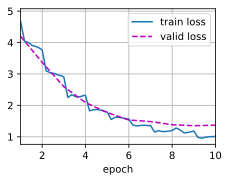

In [13]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## Classifying the Testing Set and Submitting Results on Kaggle

We will use the trained custom output network
for classification.


train loss 1.080
470.5 examples/sec on [device(type='cuda', index=0)]


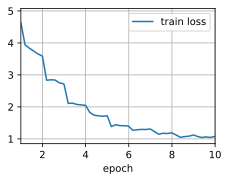

In [14]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

The above code
will generate a `submission.csv` file
to be submitted
to Kaggle.